In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../backbone","../.."])
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from focal import FocalLoss
from dataloader import create_dataloader
from metric import Metric
from ctran_ie import IECTe
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 150
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_labels = 20
num_layers = 6
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = IECTe(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                      mlp_dim=mlp_dim, backbone1=backbone1, backbone2=backbone2)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([960, 1000, 960])
torch.Size([960, 384, 384])


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) 
        outputs = torch.sigmoid(outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print("IECTe:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) 
            outputs = torch.sigmoid(outputs)

            # Calculate weighted average loss
            running_loss += loss.item()
            
            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            metric.update(outputs, labels, 1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/150
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


IECTe:
 Epoch [1/150], Loss: 0.2197, ML mAP: 0.1355, ML F1: 0.0178, ML AUC: 0.6480, ML Score: 0.3918, Bin AUC: 0.3684, Model Score: 0.3801, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [1/150], Loss: 0.2264, ML mAP: 0.2838, ML F1: 0.0511, ML AUC: 0.8425, ML Score: 0.5632, Bin AUC: 0.5263, Model Score: 0.5447, Bin F1: 0.0000

Epoch 2/150
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


IECTe:
 Epoch [2/150], Loss: 0.2143, ML mAP: 0.3842, ML F1: 0.1860, ML AUC: 0.8513, ML Score: 0.6177, Bin AUC: 0.9167, Model Score: 0.7672, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [2/150], Loss: 0.2051, ML mAP: 0.4676, ML F1: 0.2994, ML AUC: 0.8988, ML Score: 0.6832, Bin AUC: 0.4737, Model Score: 0.5784, Bin F1: 0.0000

Epoch 3/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [3/150], Loss: 0.1335, ML mAP: 0.5626, ML F1: 0.4044, ML AUC: 0.9131, ML Score: 0.7378, Bin AUC: 1.0000, Model Score: 0.8689, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [3/150], Loss: 0.1863, ML mAP: 0.5524, ML F1: 0.4014, ML AUC: 0.9175, ML Score: 0.7349, Bin AUC: 0.8947, Model Score: 0.8148, Bin F1: 0.0000

Epoch 4/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [4/150], Loss: 0.1291, ML mAP: 0.6638, ML F1: 0.5532, ML AUC: 0.9341, ML Score: 0.7990, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [4/150], Loss: 0.2118, ML mAP: 0.5584, ML F1: 0.4540, ML AUC: 0.9188, ML Score: 0.7386, Bin AUC: 1.0000, Model Score: 0.8693, Bin F1: 0.0000

Epoch 5/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [5/150], Loss: 0.0818, ML mAP: 0.7425, ML F1: 0.6427, ML AUC: 0.9531, ML Score: 0.8478, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [5/150], Loss: 0.1881, ML mAP: 0.5976, ML F1: 0.4953, ML AUC: 0.9323, ML Score: 0.7650, Bin AUC: 1.0000, Model Score: 0.8825, Bin F1: 0.0000

Epoch 6/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [6/150], Loss: 0.0698, ML mAP: 0.8016, ML F1: 0.7086, ML AUC: 0.9663, ML Score: 0.8840, Bin AUC: 0.8421, Model Score: 0.8630, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [6/150], Loss: 0.2073, ML mAP: 0.6178, ML F1: 0.5191, ML AUC: 0.9350, ML Score: 0.7764, Bin AUC: 1.0000, Model Score: 0.8882, Bin F1: 0.0000

Epoch 7/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [7/150], Loss: 0.1811, ML mAP: 0.8343, ML F1: 0.7504, ML AUC: 0.9736, ML Score: 0.9039, Bin AUC: 1.0000, Model Score: 0.9520, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [7/150], Loss: 0.1873, ML mAP: 0.6358, ML F1: 0.5307, ML AUC: 0.9416, ML Score: 0.7887, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 8/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [8/150], Loss: 0.0472, ML mAP: 0.8797, ML F1: 0.8023, ML AUC: 0.9804, ML Score: 0.9300, Bin AUC: 0.9474, Model Score: 0.9387, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [8/150], Loss: 0.1886, ML mAP: 0.6318, ML F1: 0.5616, ML AUC: 0.9395, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 9/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [9/150], Loss: 0.1342, ML mAP: 0.9061, ML F1: 0.8335, ML AUC: 0.9842, ML Score: 0.9451, Bin AUC: 1.0000, Model Score: 0.9726, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [9/150], Loss: 0.1820, ML mAP: 0.6345, ML F1: 0.5716, ML AUC: 0.9432, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 10/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [10/150], Loss: 0.1645, ML mAP: 0.9073, ML F1: 0.8390, ML AUC: 0.9838, ML Score: 0.9456, Bin AUC: 0.7895, Model Score: 0.8675, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [10/150], Loss: 0.1866, ML mAP: 0.6341, ML F1: 0.5827, ML AUC: 0.9426, ML Score: 0.7884, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 1.0000

Epoch 11/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [11/150], Loss: 0.1529, ML mAP: 0.8171, ML F1: 0.7359, ML AUC: 0.9700, ML Score: 0.8936, Bin AUC: 1.0000, Model Score: 0.9468, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [11/150], Loss: 0.2026, ML mAP: 0.5943, ML F1: 0.5077, ML AUC: 0.9330, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 0.0000

Epoch 12/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [12/150], Loss: 0.0982, ML mAP: 0.8246, ML F1: 0.7618, ML AUC: 0.9703, ML Score: 0.8975, Bin AUC: 1.0000, Model Score: 0.9487, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [12/150], Loss: 0.1658, ML mAP: 0.6183, ML F1: 0.5626, ML AUC: 0.9308, ML Score: 0.7746, Bin AUC: 0.9474, Model Score: 0.8610, Bin F1: 0.0000

Epoch 13/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [13/150], Loss: 0.0830, ML mAP: 0.8639, ML F1: 0.7960, ML AUC: 0.9799, ML Score: 0.9219, Bin AUC: 1.0000, Model Score: 0.9610, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [13/150], Loss: 0.1753, ML mAP: 0.6173, ML F1: 0.5393, ML AUC: 0.9344, ML Score: 0.7759, Bin AUC: 0.9474, Model Score: 0.8616, Bin F1: 0.0000

Epoch 14/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [14/150], Loss: 0.0714, ML mAP: 0.8889, ML F1: 0.8245, ML AUC: 0.9826, ML Score: 0.9357, Bin AUC: 1.0000, Model Score: 0.9679, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [14/150], Loss: 0.1640, ML mAP: 0.6198, ML F1: 0.5390, ML AUC: 0.9336, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 0.0000

Epoch 15/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [15/150], Loss: 0.0822, ML mAP: 0.9054, ML F1: 0.8446, ML AUC: 0.9859, ML Score: 0.9457, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [15/150], Loss: 0.1957, ML mAP: 0.6358, ML F1: 0.5631, ML AUC: 0.9349, ML Score: 0.7854, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 0.0000

Epoch 16/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [16/150], Loss: 0.0522, ML mAP: 0.9237, ML F1: 0.8557, ML AUC: 0.9885, ML Score: 0.9561, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [16/150], Loss: 0.1741, ML mAP: 0.6317, ML F1: 0.5978, ML AUC: 0.9309, ML Score: 0.7813, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 17/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [17/150], Loss: 0.0534, ML mAP: 0.9343, ML F1: 0.8784, ML AUC: 0.9906, ML Score: 0.9624, Bin AUC: 1.0000, Model Score: 0.9812, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [17/150], Loss: 0.2142, ML mAP: 0.6155, ML F1: 0.5575, ML AUC: 0.9412, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000

Epoch 18/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [18/150], Loss: 0.0380, ML mAP: 0.9439, ML F1: 0.8909, ML AUC: 0.9918, ML Score: 0.9679, Bin AUC: 1.0000, Model Score: 0.9839, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [18/150], Loss: 0.2752, ML mAP: 0.6310, ML F1: 0.5737, ML AUC: 0.9364, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 19/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [19/150], Loss: 0.0439, ML mAP: 0.9511, ML F1: 0.9001, ML AUC: 0.9934, ML Score: 0.9722, Bin AUC: 1.0000, Model Score: 0.9861, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [19/150], Loss: 0.2931, ML mAP: 0.6581, ML F1: 0.5912, ML AUC: 0.9425, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 20/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [20/150], Loss: 0.0475, ML mAP: 0.9633, ML F1: 0.9223, ML AUC: 0.9960, ML Score: 0.9796, Bin AUC: 1.0000, Model Score: 0.9898, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [20/150], Loss: 0.2950, ML mAP: 0.6401, ML F1: 0.6082, ML AUC: 0.9416, ML Score: 0.7908, Bin AUC: 0.9474, Model Score: 0.8691, Bin F1: 0.0000

Epoch 21/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [21/150], Loss: 0.0585, ML mAP: 0.9664, ML F1: 0.9263, ML AUC: 0.9952, ML Score: 0.9808, Bin AUC: 1.0000, Model Score: 0.9904, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [21/150], Loss: 0.3217, ML mAP: 0.6117, ML F1: 0.5829, ML AUC: 0.9369, ML Score: 0.7743, Bin AUC: 0.9474, Model Score: 0.8608, Bin F1: 0.0000

Epoch 22/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [22/150], Loss: 0.0497, ML mAP: 0.9685, ML F1: 0.9270, ML AUC: 0.9965, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [22/150], Loss: 0.2917, ML mAP: 0.6561, ML F1: 0.6062, ML AUC: 0.9407, ML Score: 0.7984, Bin AUC: 0.9474, Model Score: 0.8729, Bin F1: 0.0000

Epoch 23/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [23/150], Loss: 0.0514, ML mAP: 0.9760, ML F1: 0.9394, ML AUC: 0.9971, ML Score: 0.9866, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [23/150], Loss: 0.2774, ML mAP: 0.6490, ML F1: 0.5910, ML AUC: 0.9517, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 24/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [24/150], Loss: 0.0805, ML mAP: 0.9846, ML F1: 0.9544, ML AUC: 0.9983, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [24/150], Loss: 0.3043, ML mAP: 0.6486, ML F1: 0.5821, ML AUC: 0.9468, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000

Epoch 25/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [25/150], Loss: 0.1268, ML mAP: 0.9779, ML F1: 0.9491, ML AUC: 0.9975, ML Score: 0.9877, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [25/150], Loss: 0.2737, ML mAP: 0.6503, ML F1: 0.6021, ML AUC: 0.9488, ML Score: 0.7995, Bin AUC: 0.9474, Model Score: 0.8734, Bin F1: 0.0000

Epoch 26/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [26/150], Loss: 0.3923, ML mAP: 0.9845, ML F1: 0.9579, ML AUC: 0.9982, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [26/150], Loss: 0.2714, ML mAP: 0.6567, ML F1: 0.6185, ML AUC: 0.9493, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 27/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [27/150], Loss: 0.0789, ML mAP: 0.9861, ML F1: 0.9551, ML AUC: 0.9985, ML Score: 0.9923, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [27/150], Loss: 0.2697, ML mAP: 0.6606, ML F1: 0.6196, ML AUC: 0.9476, ML Score: 0.8041, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 28/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [28/150], Loss: 0.0615, ML mAP: 0.9904, ML F1: 0.9676, ML AUC: 0.9987, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [28/150], Loss: 0.2819, ML mAP: 0.6605, ML F1: 0.6324, ML AUC: 0.9483, ML Score: 0.8044, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 29/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [29/150], Loss: 0.0278, ML mAP: 0.9899, ML F1: 0.9641, ML AUC: 0.9989, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [29/150], Loss: 0.2867, ML mAP: 0.6564, ML F1: 0.6065, ML AUC: 0.9495, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 30/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [30/150], Loss: 0.0096, ML mAP: 0.9902, ML F1: 0.9651, ML AUC: 0.9990, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [30/150], Loss: 0.2825, ML mAP: 0.6605, ML F1: 0.6171, ML AUC: 0.9495, ML Score: 0.8050, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 1.0000

Epoch 31/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [31/150], Loss: 0.0360, ML mAP: 0.9564, ML F1: 0.9053, ML AUC: 0.9931, ML Score: 0.9747, Bin AUC: 1.0000, Model Score: 0.9874, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [31/150], Loss: 0.2449, ML mAP: 0.6220, ML F1: 0.5288, ML AUC: 0.9280, ML Score: 0.7750, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000

Epoch 32/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [32/150], Loss: 0.0832, ML mAP: 0.9404, ML F1: 0.8808, ML AUC: 0.9922, ML Score: 0.9663, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [32/150], Loss: 0.2688, ML mAP: 0.6204, ML F1: 0.5458, ML AUC: 0.9227, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 33/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [33/150], Loss: 0.0594, ML mAP: 0.9482, ML F1: 0.8954, ML AUC: 0.9929, ML Score: 0.9705, Bin AUC: 1.0000, Model Score: 0.9853, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [33/150], Loss: 0.3056, ML mAP: 0.6193, ML F1: 0.5341, ML AUC: 0.9315, ML Score: 0.7754, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000

Epoch 34/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [34/150], Loss: 0.1245, ML mAP: 0.9635, ML F1: 0.9225, ML AUC: 0.9956, ML Score: 0.9796, Bin AUC: 1.0000, Model Score: 0.9898, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [34/150], Loss: 0.2385, ML mAP: 0.6234, ML F1: 0.5544, ML AUC: 0.9411, ML Score: 0.7822, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 1.0000

Epoch 35/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [35/150], Loss: 0.0474, ML mAP: 0.9650, ML F1: 0.9229, ML AUC: 0.9956, ML Score: 0.9803, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [35/150], Loss: 0.3033, ML mAP: 0.6832, ML F1: 0.6089, ML AUC: 0.9353, ML Score: 0.8092, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 0.0000

Epoch 36/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [36/150], Loss: 0.0122, ML mAP: 0.9721, ML F1: 0.9314, ML AUC: 0.9964, ML Score: 0.9843, Bin AUC: 0.8947, Model Score: 0.9395, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [36/150], Loss: 0.2747, ML mAP: 0.6475, ML F1: 0.5991, ML AUC: 0.9328, ML Score: 0.7902, Bin AUC: 0.8947, Model Score: 0.8425, Bin F1: 0.0000

Epoch 37/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


IECTe:
 Epoch [37/150], Loss: 0.0761, ML mAP: 0.9686, ML F1: 0.9255, ML AUC: 0.9963, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [37/150], Loss: 0.2805, ML mAP: 0.6722, ML F1: 0.6073, ML AUC: 0.9390, ML Score: 0.8056, Bin AUC: 0.8947, Model Score: 0.8502, Bin F1: 0.0000

Epoch 38/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [38/150], Loss: 0.0662, ML mAP: 0.9679, ML F1: 0.9254, ML AUC: 0.9965, ML Score: 0.9822, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [38/150], Loss: 0.2276, ML mAP: 0.6533, ML F1: 0.6010, ML AUC: 0.9333, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 0.0000

Epoch 39/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [39/150], Loss: 0.0297, ML mAP: 0.9753, ML F1: 0.9379, ML AUC: 0.9972, ML Score: 0.9863, Bin AUC: 0.9722, Model Score: 0.9792, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [39/150], Loss: 0.3070, ML mAP: 0.6652, ML F1: 0.6081, ML AUC: 0.9206, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 0.0000

Epoch 40/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [40/150], Loss: 0.0363, ML mAP: 0.9770, ML F1: 0.9429, ML AUC: 0.9977, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [40/150], Loss: 0.2364, ML mAP: 0.6426, ML F1: 0.5768, ML AUC: 0.9294, ML Score: 0.7860, Bin AUC: 0.8947, Model Score: 0.8404, Bin F1: 0.0000

Epoch 41/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [41/150], Loss: 0.0691, ML mAP: 0.9811, ML F1: 0.9466, ML AUC: 0.9979, ML Score: 0.9895, Bin AUC: 0.9474, Model Score: 0.9684, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [41/150], Loss: 0.2463, ML mAP: 0.6558, ML F1: 0.5935, ML AUC: 0.9380, ML Score: 0.7969, Bin AUC: 0.8947, Model Score: 0.8458, Bin F1: 0.0000

Epoch 42/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [42/150], Loss: 0.1458, ML mAP: 0.9821, ML F1: 0.9430, ML AUC: 0.9981, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 0.8000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [42/150], Loss: 0.2500, ML mAP: 0.6562, ML F1: 0.6081, ML AUC: 0.9311, ML Score: 0.7936, Bin AUC: 0.8421, Model Score: 0.8179, Bin F1: 0.0000

Epoch 43/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [43/150], Loss: 0.0483, ML mAP: 0.9808, ML F1: 0.9425, ML AUC: 0.9976, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [43/150], Loss: 0.2184, ML mAP: 0.6525, ML F1: 0.5639, ML AUC: 0.9398, ML Score: 0.7961, Bin AUC: 0.9474, Model Score: 0.8717, Bin F1: 0.0000

Epoch 44/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [44/150], Loss: 0.0536, ML mAP: 0.9865, ML F1: 0.9570, ML AUC: 0.9987, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [44/150], Loss: 0.2965, ML mAP: 0.6384, ML F1: 0.5854, ML AUC: 0.9309, ML Score: 0.7847, Bin AUC: 0.9474, Model Score: 0.8660, Bin F1: 0.0000

Epoch 45/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [45/150], Loss: 0.1835, ML mAP: 0.9877, ML F1: 0.9588, ML AUC: 0.9988, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [45/150], Loss: 0.2762, ML mAP: 0.6507, ML F1: 0.6070, ML AUC: 0.9302, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 0.0000

Epoch 46/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [46/150], Loss: 0.0105, ML mAP: 0.9854, ML F1: 0.9562, ML AUC: 0.9985, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [46/150], Loss: 0.2663, ML mAP: 0.6817, ML F1: 0.6141, ML AUC: 0.9328, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000

Epoch 47/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [47/150], Loss: 0.0600, ML mAP: 0.9912, ML F1: 0.9671, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.75it/s]


Val - Epoch [47/150], Loss: 0.2534, ML mAP: 0.6583, ML F1: 0.6013, ML AUC: 0.9294, ML Score: 0.7939, Bin AUC: 0.8947, Model Score: 0.8443, Bin F1: 0.0000

Epoch 48/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [48/150], Loss: 0.0922, ML mAP: 0.9903, ML F1: 0.9631, ML AUC: 0.9988, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [48/150], Loss: 0.3150, ML mAP: 0.6456, ML F1: 0.5622, ML AUC: 0.9328, ML Score: 0.7892, Bin AUC: 0.9474, Model Score: 0.8683, Bin F1: 0.0000

Epoch 49/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [49/150], Loss: 0.1307, ML mAP: 0.9894, ML F1: 0.9616, ML AUC: 0.9990, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [49/150], Loss: 0.2989, ML mAP: 0.6703, ML F1: 0.5815, ML AUC: 0.9390, ML Score: 0.8046, Bin AUC: 0.8947, Model Score: 0.8497, Bin F1: 0.0000

Epoch 50/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [50/150], Loss: 0.0017, ML mAP: 0.9914, ML F1: 0.9710, ML AUC: 0.9989, ML Score: 0.9952, Bin AUC: 0.9722, Model Score: 0.9837, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [50/150], Loss: 0.2914, ML mAP: 0.6623, ML F1: 0.6061, ML AUC: 0.9345, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 0.0000

Epoch 51/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [51/150], Loss: 0.0544, ML mAP: 0.9937, ML F1: 0.9720, ML AUC: 0.9994, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [51/150], Loss: 0.3438, ML mAP: 0.6383, ML F1: 0.5800, ML AUC: 0.9364, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 0.0000

Epoch 52/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [52/150], Loss: 0.0303, ML mAP: 0.9919, ML F1: 0.9706, ML AUC: 0.9992, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [52/150], Loss: 0.3112, ML mAP: 0.6641, ML F1: 0.6145, ML AUC: 0.9413, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 1.0000

Epoch 53/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [53/150], Loss: 0.0333, ML mAP: 0.9953, ML F1: 0.9803, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [53/150], Loss: 0.2689, ML mAP: 0.6748, ML F1: 0.6329, ML AUC: 0.9452, ML Score: 0.8100, Bin AUC: 0.9474, Model Score: 0.8787, Bin F1: 0.0000

Epoch 54/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [54/150], Loss: 0.0633, ML mAP: 0.9953, ML F1: 0.9803, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [54/150], Loss: 0.3338, ML mAP: 0.6655, ML F1: 0.6142, ML AUC: 0.9391, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 1.0000

Epoch 55/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [55/150], Loss: 0.0944, ML mAP: 0.9965, ML F1: 0.9788, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [55/150], Loss: 0.3124, ML mAP: 0.6649, ML F1: 0.6017, ML AUC: 0.9380, ML Score: 0.8015, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000

Epoch 56/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [56/150], Loss: 0.0302, ML mAP: 0.9965, ML F1: 0.9827, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [56/150], Loss: 0.3192, ML mAP: 0.6676, ML F1: 0.6060, ML AUC: 0.9382, ML Score: 0.8029, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 1.0000

Epoch 57/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [57/150], Loss: 0.1461, ML mAP: 0.9971, ML F1: 0.9829, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [57/150], Loss: 0.2948, ML mAP: 0.6605, ML F1: 0.5850, ML AUC: 0.9340, ML Score: 0.7972, Bin AUC: 0.9474, Model Score: 0.8723, Bin F1: 0.0000

Epoch 58/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [58/150], Loss: 0.0070, ML mAP: 0.9969, ML F1: 0.9814, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [58/150], Loss: 0.3462, ML mAP: 0.6608, ML F1: 0.5998, ML AUC: 0.9347, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 59/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [59/150], Loss: 0.0058, ML mAP: 0.9976, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [59/150], Loss: 0.3481, ML mAP: 0.6754, ML F1: 0.6127, ML AUC: 0.9413, ML Score: 0.8083, Bin AUC: 0.9474, Model Score: 0.8779, Bin F1: 0.0000

Epoch 60/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [60/150], Loss: 0.0167, ML mAP: 0.9963, ML F1: 0.9876, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [60/150], Loss: 0.3583, ML mAP: 0.6698, ML F1: 0.6077, ML AUC: 0.9382, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 1.0000

Epoch 61/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [61/150], Loss: 0.0043, ML mAP: 0.9961, ML F1: 0.9907, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [61/150], Loss: 0.3815, ML mAP: 0.6655, ML F1: 0.5864, ML AUC: 0.9398, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.6667

Epoch 62/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [62/150], Loss: 0.0012, ML mAP: 0.9984, ML F1: 0.9891, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [62/150], Loss: 0.3772, ML mAP: 0.6658, ML F1: 0.5963, ML AUC: 0.9358, ML Score: 0.8008, Bin AUC: 0.9474, Model Score: 0.8741, Bin F1: 0.6667

Epoch 63/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [63/150], Loss: 0.0100, ML mAP: 0.9986, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [63/150], Loss: 0.3824, ML mAP: 0.6656, ML F1: 0.6069, ML AUC: 0.9390, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 1.0000

Epoch 64/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [64/150], Loss: 0.0181, ML mAP: 0.9982, ML F1: 0.9874, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [64/150], Loss: 0.4025, ML mAP: 0.6696, ML F1: 0.6041, ML AUC: 0.9392, ML Score: 0.8044, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 65/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [65/150], Loss: 0.1414, ML mAP: 0.9992, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [65/150], Loss: 0.3777, ML mAP: 0.6666, ML F1: 0.6294, ML AUC: 0.9400, ML Score: 0.8033, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 66/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [66/150], Loss: 0.0412, ML mAP: 0.9992, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [66/150], Loss: 0.3806, ML mAP: 0.6644, ML F1: 0.6099, ML AUC: 0.9395, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.6667

Epoch 67/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [67/150], Loss: 0.0015, ML mAP: 0.9990, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [67/150], Loss: 0.3880, ML mAP: 0.6746, ML F1: 0.6258, ML AUC: 0.9389, ML Score: 0.8067, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 1.0000

Epoch 68/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [68/150], Loss: 0.0043, ML mAP: 0.9983, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [68/150], Loss: 0.3872, ML mAP: 0.6704, ML F1: 0.6151, ML AUC: 0.9391, ML Score: 0.8047, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.6667

Epoch 69/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [69/150], Loss: 0.0031, ML mAP: 0.9981, ML F1: 0.9894, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [69/150], Loss: 0.3661, ML mAP: 0.6664, ML F1: 0.6023, ML AUC: 0.9377, ML Score: 0.8021, Bin AUC: 0.9474, Model Score: 0.8747, Bin F1: 0.6667

Epoch 70/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [70/150], Loss: 0.0008, ML mAP: 0.9987, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [70/150], Loss: 0.3757, ML mAP: 0.6634, ML F1: 0.6033, ML AUC: 0.9370, ML Score: 0.8002, Bin AUC: 0.9474, Model Score: 0.8738, Bin F1: 0.6667

Epoch 71/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [71/150], Loss: 0.0342, ML mAP: 0.9705, ML F1: 0.9334, ML AUC: 0.9963, ML Score: 0.9834, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [71/150], Loss: 0.3680, ML mAP: 0.5987, ML F1: 0.5670, ML AUC: 0.9117, ML Score: 0.7552, Bin AUC: 0.9474, Model Score: 0.8513, Bin F1: 0.6667

Epoch 72/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [72/150], Loss: 0.1262, ML mAP: 0.9658, ML F1: 0.9142, ML AUC: 0.9955, ML Score: 0.9807, Bin AUC: 0.9722, Model Score: 0.9765, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [72/150], Loss: 0.2405, ML mAP: 0.6362, ML F1: 0.5750, ML AUC: 0.9211, ML Score: 0.7787, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000

Epoch 73/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [73/150], Loss: 0.0299, ML mAP: 0.9734, ML F1: 0.9272, ML AUC: 0.9965, ML Score: 0.9849, Bin AUC: 0.9722, Model Score: 0.9786, Bin F1: 0.5000


100%|██████████| 28/28 [00:05<00:00,  4.75it/s]


Val - Epoch [73/150], Loss: 0.2297, ML mAP: 0.6582, ML F1: 0.5982, ML AUC: 0.9271, ML Score: 0.7926, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 74/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [74/150], Loss: 0.2642, ML mAP: 0.9753, ML F1: 0.9385, ML AUC: 0.9970, ML Score: 0.9862, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [74/150], Loss: 0.2365, ML mAP: 0.6347, ML F1: 0.5999, ML AUC: 0.9235, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 75/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [75/150], Loss: 0.0320, ML mAP: 0.9770, ML F1: 0.9411, ML AUC: 0.9975, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [75/150], Loss: 0.2901, ML mAP: 0.6433, ML F1: 0.5916, ML AUC: 0.9280, ML Score: 0.7857, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 76/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [76/150], Loss: 0.1644, ML mAP: 0.9830, ML F1: 0.9487, ML AUC: 0.9982, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [76/150], Loss: 0.2726, ML mAP: 0.6481, ML F1: 0.5948, ML AUC: 0.9347, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 1.0000

Epoch 77/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [77/150], Loss: 0.0189, ML mAP: 0.9856, ML F1: 0.9581, ML AUC: 0.9985, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [77/150], Loss: 0.1755, ML mAP: 0.6626, ML F1: 0.6033, ML AUC: 0.9449, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

Epoch 78/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [78/150], Loss: 0.1249, ML mAP: 0.9846, ML F1: 0.9510, ML AUC: 0.9981, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [78/150], Loss: 0.2442, ML mAP: 0.6448, ML F1: 0.5770, ML AUC: 0.9427, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 0.0000

Epoch 79/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [79/150], Loss: 0.0045, ML mAP: 0.9898, ML F1: 0.9702, ML AUC: 0.9988, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [79/150], Loss: 0.3018, ML mAP: 0.6284, ML F1: 0.6011, ML AUC: 0.9403, ML Score: 0.7844, Bin AUC: 0.9474, Model Score: 0.8659, Bin F1: 0.0000

Epoch 80/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [80/150], Loss: 0.1035, ML mAP: 0.9898, ML F1: 0.9600, ML AUC: 0.9989, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [80/150], Loss: 0.2549, ML mAP: 0.6422, ML F1: 0.6114, ML AUC: 0.9417, ML Score: 0.7919, Bin AUC: 0.9474, Model Score: 0.8697, Bin F1: 0.0000

Epoch 81/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [81/150], Loss: 0.0539, ML mAP: 0.9836, ML F1: 0.9502, ML AUC: 0.9982, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [81/150], Loss: 0.2607, ML mAP: 0.6318, ML F1: 0.5847, ML AUC: 0.9385, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 82/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [82/150], Loss: 0.0035, ML mAP: 0.9927, ML F1: 0.9692, ML AUC: 0.9993, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [82/150], Loss: 0.3043, ML mAP: 0.6485, ML F1: 0.5705, ML AUC: 0.9422, ML Score: 0.7954, Bin AUC: 0.9474, Model Score: 0.8714, Bin F1: 0.0000

Epoch 83/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [83/150], Loss: 0.2118, ML mAP: 0.9903, ML F1: 0.9677, ML AUC: 0.9992, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [83/150], Loss: 0.2840, ML mAP: 0.6508, ML F1: 0.6022, ML AUC: 0.9388, ML Score: 0.7948, Bin AUC: 0.9474, Model Score: 0.8711, Bin F1: 0.0000

Epoch 84/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [84/150], Loss: 0.0703, ML mAP: 0.9894, ML F1: 0.9657, ML AUC: 0.9988, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [84/150], Loss: 0.3490, ML mAP: 0.6401, ML F1: 0.5728, ML AUC: 0.9410, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 85/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [85/150], Loss: 0.0749, ML mAP: 0.9880, ML F1: 0.9590, ML AUC: 0.9986, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [85/150], Loss: 0.3498, ML mAP: 0.6584, ML F1: 0.6041, ML AUC: 0.9298, ML Score: 0.7941, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 86/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [86/150], Loss: 0.0024, ML mAP: 0.9931, ML F1: 0.9732, ML AUC: 0.9994, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [86/150], Loss: 0.3819, ML mAP: 0.6539, ML F1: 0.6347, ML AUC: 0.9353, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 87/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [87/150], Loss: 0.0602, ML mAP: 0.9942, ML F1: 0.9756, ML AUC: 0.9996, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [87/150], Loss: 0.2770, ML mAP: 0.6588, ML F1: 0.6293, ML AUC: 0.9336, ML Score: 0.7962, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 88/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [88/150], Loss: 0.1207, ML mAP: 0.9918, ML F1: 0.9656, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [88/150], Loss: 0.3173, ML mAP: 0.6407, ML F1: 0.6192, ML AUC: 0.9298, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 89/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [89/150], Loss: 0.0815, ML mAP: 0.9873, ML F1: 0.9630, ML AUC: 0.9982, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [89/150], Loss: 0.3202, ML mAP: 0.6370, ML F1: 0.6258, ML AUC: 0.9307, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 90/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [90/150], Loss: 0.0077, ML mAP: 0.9937, ML F1: 0.9746, ML AUC: 0.9994, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [90/150], Loss: 0.3692, ML mAP: 0.6458, ML F1: 0.5988, ML AUC: 0.9199, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000

Epoch 91/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [91/150], Loss: 0.0007, ML mAP: 0.9963, ML F1: 0.9814, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [91/150], Loss: 0.3970, ML mAP: 0.6431, ML F1: 0.5958, ML AUC: 0.9227, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000

Epoch 92/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [92/150], Loss: 0.0128, ML mAP: 0.9972, ML F1: 0.9820, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [92/150], Loss: 0.3352, ML mAP: 0.6559, ML F1: 0.5977, ML AUC: 0.9276, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000

Epoch 93/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [93/150], Loss: 0.0662, ML mAP: 0.9946, ML F1: 0.9775, ML AUC: 0.9996, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [93/150], Loss: 0.3127, ML mAP: 0.6496, ML F1: 0.6060, ML AUC: 0.9285, ML Score: 0.7891, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 94/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [94/150], Loss: 0.0011, ML mAP: 0.9960, ML F1: 0.9790, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [94/150], Loss: 0.3512, ML mAP: 0.6596, ML F1: 0.5962, ML AUC: 0.9256, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 95/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [95/150], Loss: 0.0773, ML mAP: 0.9962, ML F1: 0.9781, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [95/150], Loss: 0.3088, ML mAP: 0.6616, ML F1: 0.6116, ML AUC: 0.9288, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 96/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [96/150], Loss: 0.0008, ML mAP: 0.9948, ML F1: 0.9815, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [96/150], Loss: 0.3378, ML mAP: 0.6675, ML F1: 0.5795, ML AUC: 0.9282, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 97/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [97/150], Loss: 0.0033, ML mAP: 0.9964, ML F1: 0.9825, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [97/150], Loss: 0.3343, ML mAP: 0.6532, ML F1: 0.5734, ML AUC: 0.9343, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 98/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [98/150], Loss: 0.0473, ML mAP: 0.9968, ML F1: 0.9824, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [98/150], Loss: 0.2526, ML mAP: 0.6650, ML F1: 0.6086, ML AUC: 0.9420, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 99/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [99/150], Loss: 0.0030, ML mAP: 0.9964, ML F1: 0.9850, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [99/150], Loss: 0.2541, ML mAP: 0.6453, ML F1: 0.5958, ML AUC: 0.9419, ML Score: 0.7936, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 0.6667

Epoch 100/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [100/150], Loss: 0.0231, ML mAP: 0.9943, ML F1: 0.9776, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [100/150], Loss: 0.3610, ML mAP: 0.6188, ML F1: 0.5605, ML AUC: 0.9211, ML Score: 0.7699, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 0.6667

Epoch 101/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [101/150], Loss: 0.0129, ML mAP: 0.9962, ML F1: 0.9810, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [101/150], Loss: 0.4512, ML mAP: 0.6307, ML F1: 0.5730, ML AUC: 0.9161, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 1.0000

Epoch 102/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [102/150], Loss: 0.0007, ML mAP: 0.9974, ML F1: 0.9819, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [102/150], Loss: 0.3785, ML mAP: 0.6319, ML F1: 0.5925, ML AUC: 0.9196, ML Score: 0.7758, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000

Epoch 103/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [103/150], Loss: 0.0124, ML mAP: 0.9971, ML F1: 0.9847, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [103/150], Loss: 0.3525, ML mAP: 0.6370, ML F1: 0.6225, ML AUC: 0.9214, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 104/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [104/150], Loss: 0.0045, ML mAP: 0.9966, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [104/150], Loss: 0.3758, ML mAP: 0.6271, ML F1: 0.5733, ML AUC: 0.9154, ML Score: 0.7712, Bin AUC: 0.9474, Model Score: 0.8593, Bin F1: 0.0000

Epoch 105/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [105/150], Loss: 0.0060, ML mAP: 0.9976, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [105/150], Loss: 0.4025, ML mAP: 0.6357, ML F1: 0.5870, ML AUC: 0.9190, ML Score: 0.7773, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000

Epoch 106/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [106/150], Loss: 0.1398, ML mAP: 0.9988, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [106/150], Loss: 0.3747, ML mAP: 0.6475, ML F1: 0.5988, ML AUC: 0.9263, ML Score: 0.7869, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 1.0000

Epoch 107/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [107/150], Loss: 0.0028, ML mAP: 0.9980, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [107/150], Loss: 0.3465, ML mAP: 0.6566, ML F1: 0.5859, ML AUC: 0.9207, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 108/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [108/150], Loss: 0.0215, ML mAP: 0.9980, ML F1: 0.9875, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [108/150], Loss: 0.3782, ML mAP: 0.6620, ML F1: 0.6155, ML AUC: 0.9227, ML Score: 0.7923, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 109/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [109/150], Loss: 0.0995, ML mAP: 0.9975, ML F1: 0.9848, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [109/150], Loss: 0.3179, ML mAP: 0.6566, ML F1: 0.6042, ML AUC: 0.9371, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 110/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [110/150], Loss: 0.0029, ML mAP: 0.9977, ML F1: 0.9874, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [110/150], Loss: 0.3001, ML mAP: 0.6442, ML F1: 0.5982, ML AUC: 0.9357, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 111/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [111/150], Loss: 0.0081, ML mAP: 0.9985, ML F1: 0.9855, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [111/150], Loss: 0.3996, ML mAP: 0.6477, ML F1: 0.5860, ML AUC: 0.9295, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 112/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [112/150], Loss: 0.0008, ML mAP: 0.9984, ML F1: 0.9895, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [112/150], Loss: 0.3015, ML mAP: 0.6525, ML F1: 0.5842, ML AUC: 0.9342, ML Score: 0.7934, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000

Epoch 113/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [113/150], Loss: 0.0004, ML mAP: 0.9985, ML F1: 0.9867, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [113/150], Loss: 0.2477, ML mAP: 0.6597, ML F1: 0.6064, ML AUC: 0.9352, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 1.0000

Epoch 114/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [114/150], Loss: 0.0074, ML mAP: 0.9983, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [114/150], Loss: 0.2670, ML mAP: 0.6568, ML F1: 0.6114, ML AUC: 0.9393, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 0.6667

Epoch 115/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [115/150], Loss: 0.0010, ML mAP: 0.9992, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [115/150], Loss: 0.2622, ML mAP: 0.6592, ML F1: 0.5827, ML AUC: 0.9413, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 116/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [116/150], Loss: 0.0049, ML mAP: 0.9997, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [116/150], Loss: 0.3682, ML mAP: 0.6706, ML F1: 0.5768, ML AUC: 0.9457, ML Score: 0.8082, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 1.0000

Epoch 117/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [117/150], Loss: 0.0017, ML mAP: 0.9994, ML F1: 0.9930, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [117/150], Loss: 0.3563, ML mAP: 0.6715, ML F1: 0.5892, ML AUC: 0.9439, ML Score: 0.8077, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 1.0000

Epoch 118/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [118/150], Loss: 0.0249, ML mAP: 0.9997, ML F1: 0.9936, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [118/150], Loss: 0.3562, ML mAP: 0.6760, ML F1: 0.5999, ML AUC: 0.9396, ML Score: 0.8078, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 1.0000

Epoch 119/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [119/150], Loss: 0.1158, ML mAP: 0.9994, ML F1: 0.9953, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.74it/s]


Val - Epoch [119/150], Loss: 0.3673, ML mAP: 0.6736, ML F1: 0.6054, ML AUC: 0.9353, ML Score: 0.8044, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 120/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [120/150], Loss: 0.0022, ML mAP: 0.9986, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [120/150], Loss: 0.3747, ML mAP: 0.6687, ML F1: 0.5828, ML AUC: 0.9318, ML Score: 0.8003, Bin AUC: 0.9474, Model Score: 0.8738, Bin F1: 0.0000

Epoch 121/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [121/150], Loss: 0.0028, ML mAP: 0.9994, ML F1: 0.9952, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


Val - Epoch [121/150], Loss: 0.4468, ML mAP: 0.6670, ML F1: 0.5975, ML AUC: 0.9329, ML Score: 0.7999, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 122/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [122/150], Loss: 0.0005, ML mAP: 0.9992, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [122/150], Loss: 0.3626, ML mAP: 0.6678, ML F1: 0.6026, ML AUC: 0.9372, ML Score: 0.8025, Bin AUC: 0.9474, Model Score: 0.8749, Bin F1: 0.0000

Epoch 123/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [123/150], Loss: 0.0523, ML mAP: 0.9998, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [123/150], Loss: 0.3425, ML mAP: 0.6792, ML F1: 0.6169, ML AUC: 0.9398, ML Score: 0.8095, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 1.0000

Epoch 124/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [124/150], Loss: 0.0009, ML mAP: 0.9995, ML F1: 0.9927, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [124/150], Loss: 0.3803, ML mAP: 0.6596, ML F1: 0.5842, ML AUC: 0.9366, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 125/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [125/150], Loss: 0.0713, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [125/150], Loss: 0.3793, ML mAP: 0.6664, ML F1: 0.5902, ML AUC: 0.9396, ML Score: 0.8030, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 0.6667

Epoch 126/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [126/150], Loss: 0.0015, ML mAP: 0.9996, ML F1: 0.9931, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [126/150], Loss: 0.4019, ML mAP: 0.6581, ML F1: 0.5890, ML AUC: 0.9355, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 127/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [127/150], Loss: 0.0035, ML mAP: 0.9996, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [127/150], Loss: 0.3458, ML mAP: 0.6616, ML F1: 0.5951, ML AUC: 0.9362, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 128/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [128/150], Loss: 0.0448, ML mAP: 0.9990, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [128/150], Loss: 0.3571, ML mAP: 0.6635, ML F1: 0.5999, ML AUC: 0.9385, ML Score: 0.8010, Bin AUC: 0.9474, Model Score: 0.8742, Bin F1: 0.6667

Epoch 129/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [129/150], Loss: 0.0039, ML mAP: 0.9995, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [129/150], Loss: 0.3676, ML mAP: 0.6608, ML F1: 0.5915, ML AUC: 0.9333, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 1.0000

Epoch 130/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [130/150], Loss: 0.0053, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [130/150], Loss: 0.3658, ML mAP: 0.6690, ML F1: 0.6226, ML AUC: 0.9378, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 131/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [131/150], Loss: 0.0012, ML mAP: 0.9998, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [131/150], Loss: 0.4175, ML mAP: 0.6685, ML F1: 0.6149, ML AUC: 0.9380, ML Score: 0.8032, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 1.0000

Epoch 132/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [132/150], Loss: 0.2022, ML mAP: 0.9996, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [132/150], Loss: 0.4088, ML mAP: 0.6676, ML F1: 0.6066, ML AUC: 0.9416, ML Score: 0.8046, Bin AUC: 1.0000, Model Score: 0.9023, Bin F1: 1.0000

Epoch 133/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [133/150], Loss: 0.0003, ML mAP: 0.9996, ML F1: 0.9956, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [133/150], Loss: 0.4020, ML mAP: 0.6589, ML F1: 0.6113, ML AUC: 0.9378, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 134/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [134/150], Loss: 0.0646, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [134/150], Loss: 0.4119, ML mAP: 0.6596, ML F1: 0.6177, ML AUC: 0.9403, ML Score: 0.8000, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 135/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [135/150], Loss: 0.0174, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [135/150], Loss: 0.4516, ML mAP: 0.6561, ML F1: 0.6048, ML AUC: 0.9381, ML Score: 0.7971, Bin AUC: 0.9474, Model Score: 0.8722, Bin F1: 0.6667

Epoch 136/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [136/150], Loss: 0.0012, ML mAP: 0.9999, ML F1: 0.9978, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [136/150], Loss: 0.4532, ML mAP: 0.6631, ML F1: 0.5961, ML AUC: 0.9394, ML Score: 0.8013, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 1.0000

Epoch 137/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [137/150], Loss: 0.0145, ML mAP: 0.9997, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [137/150], Loss: 0.3723, ML mAP: 0.6719, ML F1: 0.6003, ML AUC: 0.9404, ML Score: 0.8062, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 1.0000

Epoch 138/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [138/150], Loss: 0.0005, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [138/150], Loss: 0.3893, ML mAP: 0.6755, ML F1: 0.6068, ML AUC: 0.9412, ML Score: 0.8084, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 1.0000

Epoch 139/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [139/150], Loss: 0.1266, ML mAP: 0.9999, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [139/150], Loss: 0.4058, ML mAP: 0.6801, ML F1: 0.5993, ML AUC: 0.9420, ML Score: 0.8111, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 1.0000

Epoch 140/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [140/150], Loss: 0.0037, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [140/150], Loss: 0.4025, ML mAP: 0.6731, ML F1: 0.6066, ML AUC: 0.9395, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000

Epoch 141/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [141/150], Loss: 0.1148, ML mAP: 0.9999, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Val - Epoch [141/150], Loss: 0.3674, ML mAP: 0.6763, ML F1: 0.6007, ML AUC: 0.9414, ML Score: 0.8089, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 1.0000

Epoch 142/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [142/150], Loss: 0.0012, ML mAP: 0.9996, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [142/150], Loss: 0.4514, ML mAP: 0.6731, ML F1: 0.5962, ML AUC: 0.9405, ML Score: 0.8068, Bin AUC: 1.0000, Model Score: 0.9034, Bin F1: 1.0000

Epoch 143/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [143/150], Loss: 0.0003, ML mAP: 0.9998, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [143/150], Loss: 0.4333, ML mAP: 0.6721, ML F1: 0.5996, ML AUC: 0.9394, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000

Epoch 144/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [144/150], Loss: 0.0047, ML mAP: 0.9999, ML F1: 0.9984, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [144/150], Loss: 0.4264, ML mAP: 0.6763, ML F1: 0.6070, ML AUC: 0.9389, ML Score: 0.8076, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 1.0000

Epoch 145/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [145/150], Loss: 0.0005, ML mAP: 0.9997, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [145/150], Loss: 0.4471, ML mAP: 0.6762, ML F1: 0.6108, ML AUC: 0.9397, ML Score: 0.8079, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 1.0000

Epoch 146/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


IECTe:
 Epoch [146/150], Loss: 0.0135, ML mAP: 1.0000, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


Val - Epoch [146/150], Loss: 0.4620, ML mAP: 0.6634, ML F1: 0.5924, ML AUC: 0.9392, ML Score: 0.8013, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 1.0000

Epoch 147/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [147/150], Loss: 0.0005, ML mAP: 0.9999, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [147/150], Loss: 0.4364, ML mAP: 0.6744, ML F1: 0.6083, ML AUC: 0.9404, ML Score: 0.8074, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 1.0000

Epoch 148/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [148/150], Loss: 0.0004, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [148/150], Loss: 0.4584, ML mAP: 0.6716, ML F1: 0.6025, ML AUC: 0.9407, ML Score: 0.8061, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 1.0000

Epoch 149/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [149/150], Loss: 0.0021, ML mAP: 0.9999, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


Val - Epoch [149/150], Loss: 0.4296, ML mAP: 0.6768, ML F1: 0.6062, ML AUC: 0.9407, ML Score: 0.8087, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 1.0000

Epoch 150/150
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


IECTe:
 Epoch [150/150], Loss: 0.0003, ML mAP: 0.9999, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.66it/s]

Val - Epoch [150/150], Loss: 0.4404, ML mAP: 0.6715, ML F1: 0.6021, ML AUC: 0.9414, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000



In [6]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:06<00:00,  4.58it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.8947
      1       0.6833    0.6667  1       1
      2       0.6833    0.6667  1       1
      3       0.6833    0.6667  1       1
      4       0.6833    0.6667  1       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.5167    0.6667  0.6667  1
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.5167    0.6667  0.6667  1
     13       0.6833    0.6667  1       1
     14       0.5167    0.6667  0.6667  0.9474
     15       0.6833    0.6667  1       1
     16       0.35      0.3333  0       0.8947
     17       0.35      0.3333  0       0.9474
     18       0.5167    0.6667  0.6667  1
     19       0.7       0.5     0.6667  1


[0.9055405292267967, 138, 2.7248368952908053e-06]


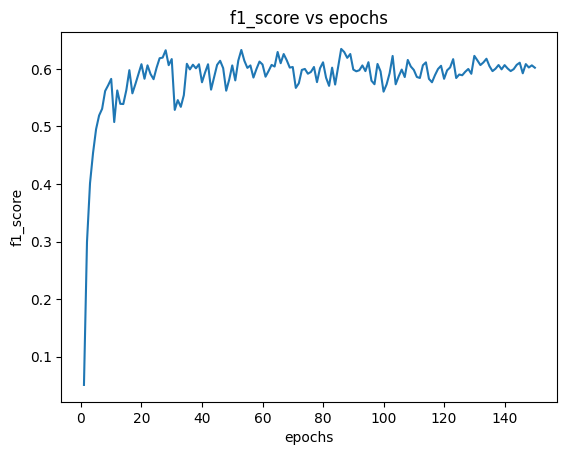

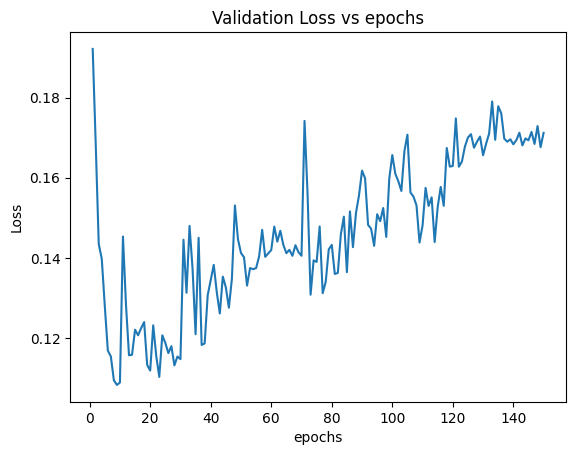

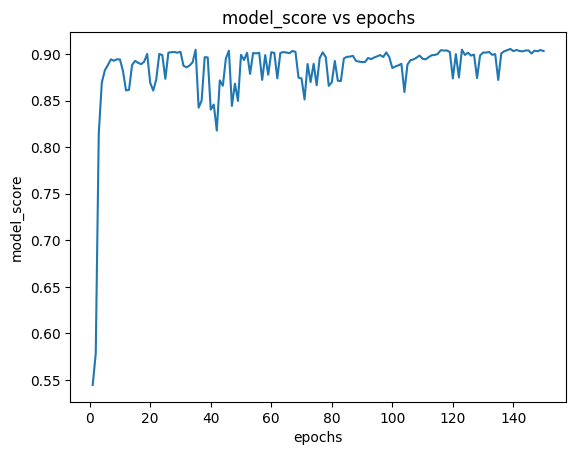

In [7]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

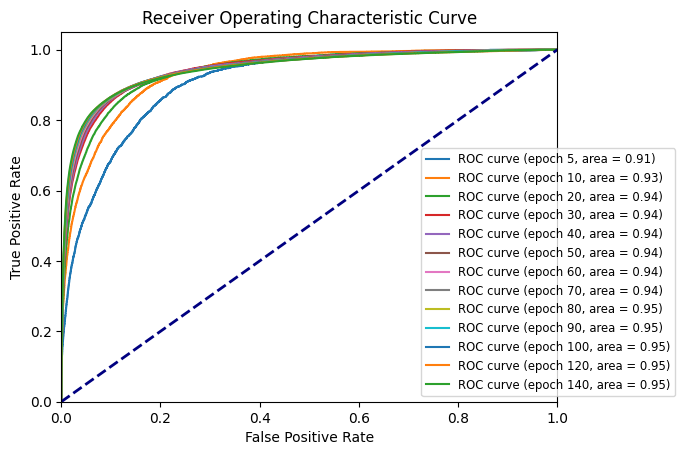

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)